<a href="https://colab.research.google.com/github/wgova/time_series_trade/blob/master/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Beneficiation of Minerals Research Group](https://ie.sun.ac.za/wp-content/themes/natural/lib/timthumb.php?src=/wp-content/uploads/2018/05/bm.jpg&w=770&h=197&zc=1)

##### Prepared by Webster Gova for the Beneficiation of Minerals Research Group at Stellenbosch University

In [1]:
!pip install -q oec
import oec
import pandas as pd
import numpy as np
import os, os.path, csv, requests, pathlib
import math
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Unhash if you are using Google colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

## OED data API functions

In [ ]:
def build_call(*args):
    call_url = 'http://atlas.media.mit.edu/'
    for val in args:
        call_url += str(val) + '/'
    return call_url


def request_data(call_url):
    r = requests.get(call_url)
    response_dict = r.json()
    json_list = response_dict['data']  # list of dicts containing data
    return json_list


def get_countries(filename=None):
    call = build_call('attr', 'country')
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def get_products(classification, filename=None):
    call = build_call('attr', classification)
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def get_trade(classification, trade_flow, year, origin, destination,product, filename=None):
    call = build_call(classification, trade_flow, year, origin, destination,
                      product)
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def trade_params(classification, trade_flow, year, origin, destination,product):
    parameters = {'classification': classification,
                  'trade_flow': trade_flow,
                  'year': year,
                  'origin': origin,
                  'destination': destination,
                  'product': product}
    return parameters


def get_header(json_list):
    header = set()
    for dict in json_list:
        header.update(dict.keys())
    header = list(header)
    header.sort()
    return header


def create_csv(json_list, filename):
    with open(filename, 'w') as csvfile:
        header = get_header(json_list)
        cw = csv.writer(csvfile)
        cw.writerow(header)
        for dict in json_list:
            row = dict_to_list(dict, header)
            cw.writerow(row)


def dict_to_list(dict, header):
    row = []
    for field in header:
        if field in dict:
            row.append(str(dict[field]))
        else:
            row.append(None)
    return row

## Generate dataset

In [4]:
# create a list of HS/SITC codes you'd like to download
trade_codes = ['6519','6531','7763','7711','7188']
# direct your downloads to the loacation you'd like to store them
PATH = '/content/drive/My Drive/Stellenbosch/sitc_data'
os.chdir(PATH)
# Specify the trade codes classification you would like to download
trade_classification = 'sitc'
# Describe a function to download list of country names and product names
def countries_and_products():
  countries = oec.get_countries()
  products = oec.get_products(trade_classification)
  create_csv(countries,f'{PATH}/list_countries.csv')
  create_csv(products,f'{PATH}/list_products.csv')

In [ ]:
# implement the function
countries_and_products()

In [ ]:
import os.path
from os import path
# Describe a function to download product data
def download_data(list_of_codes):
  for i in trade_codes:
    csv_name = f"{trade_classification}-{i}"
    # Set parameters to extract top exporters from the API documentation
    params = {'classification': trade_classification,
          'trade_flow': 'export',
          'year': 'all',
          'origin': 'show', #Set origin to all for comparison
          'destination': 'all',
          'product': i} #Set code for product of interest
    print(f'Data for {i} processed.....')
    oec_data = get_trade(**params)
    # Save the results in CSV file
    if path.exists(PATH):
      create_csv(oec_data,f'{csv_name}.csv')
    else:
      print('Choose destination directory')

In [12]:
download_data(trade_codes)

Data for 6519 processed.....
Data for 6531 processed.....
Data for 8471 processed.....
Data for 6571 processed.....
Data for 7849 processed.....
Data for 7810 processed.....
Data for 7842 processed.....
Data for 7764 processed.....
Data for 7723 processed.....
Data for 7522 processed.....
Data for 2924 processed.....
Data for 5419 processed.....
Data for 5417 processed.....
Data for 7763 processed.....
Data for 7711 processed.....
Data for 7188 processed.....


In [ ]:
import pandas as pd
import numpy as np
import os, os.path, csv, requests, pathlib
import math
from datetime import datetime

# specify columns you would like to add to your dataframes
include_list = ['year','origin_id','sitc_id','export_val','export_rca']
def create_df(path):
    # scan through the folder where product data is stored
    trade_data = [i for i in os.listdir(path) if i.startswith('sitc') and '.csv' in i]
    trade_history = []
    for file in trade_data:
        file_name = pd.read_csv(file,usecols=include_list,parse_dates=['year'])#, index_col=['year'])
        trade_history.append(file_name)
        products_dataframe = pd.concat(trade_history)
    return products_dataframe

In [ ]:
trade_df = create_df(PATH)

In [15]:
country_list = pd.read_csv('list_countries.csv',usecols=['id','name'],
                        na_values='',na_filter=True)
country_list.rename(columns=lambda x: x.replace('name','country'), inplace=True)
country_list.rename(columns=lambda x: x.replace('id','origin_id'), inplace=True)
country_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   origin_id  305 non-null    object
 1   country    305 non-null    object
dtypes: object(2)
memory usage: 4.9+ KB


In [16]:
trade_dframe = trade_df.merge(country_list, on=['origin_id'],how='inner')
trade_dframe['sitc_id'].astype('category')
trade_dframe.fillna(0,inplace=True)
trade_dframe.head(2)

,export_rca,export_val,origin_id,sitc_id,year,country
0,0.020916,3000.0,afciv,606519,1962.0,Cote d'Ivoire
1,0.084925,15000.0,afciv,606519,1963.0,Cote d'Ivoire


In [17]:
products = pd.read_csv(f'{PATH}/list_products.csv',usecols=['id','name','display_id'])
products.rename(columns={'id':'sitc_id'},inplace=True)
products = products[products['display_id'].isin(trade_codes)]
products['name'] = products.name.astype('category')
products['sitc_id'] = products.sitc_id.astype(int)
trade_dframe['product_name'] = trade_dframe.sitc_id.map(products.set_index('sitc_id')['name'].to_dict())
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 48 to 899
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   display_id  16 non-null     object  
 1   sitc_id     16 non-null     int64   
 2   name        16 non-null     category
dtypes: category(1), int64(1), object(1)
memory usage: 1.1+ KB


In [ ]:
agg_product = pd.pivot_table(trade_dframe, index='year', columns='product_name', values='export_val', aggfunc=np.mean)
agg_product.fillna(0,inplace=True)

In [19]:
# agg_product.rename(columns=products.set_index('sitc_id')['name'], inplace=True)
# agg_product.rename(columns=prod_dict,inplace=True)
agg_product.head()

product_name,Cars,"Diodes, Transistors and Photocells",Electrical Resistors,Electrical Transformers,Electronic Microcircuits,Felt,Medicaments,Miscellaneous Engines,Non-Medicinal Pharmaceutical Products,Personal Computers,Pharmaceutical Flora,Synthetic Woven Fabrics,Textile Fabrics Clothing Accessories,Vehicle Bodies,Vehicles Parts and Accessories,Yarn of Textile Fibers
year,,,,,,,,,,,,,,,,
1962.0,2.871447e+07,0.0,0.0,0.0,0.0,0.0,6.727030e+06,1.715595e+06,1.139305e+06,0.0,659447.368421,0.0,2.608803e+06,1.828409e+07,0.0,1.409417e+06
1963.0,3.151773e+07,0.0,0.0,0.0,0.0,0.0,7.597175e+06,1.305946e+06,1.174824e+06,0.0,678770.491803,0.0,2.756342e+06,2.031198e+07,0.0,1.428806e+06
1964.0,3.678137e+07,0.0,0.0,0.0,0.0,0.0,8.213614e+06,1.811143e+06,1.271000e+06,0.0,652620.967742,0.0,3.009349e+06,2.308392e+07,0.0,1.537761e+06
1965.0,4.075167e+07,0.0,0.0,0.0,0.0,0.0,9.497354e+06,1.649982e+06,1.601159e+06,0.0,746496.124031,0.0,2.868571e+06,2.672369e+07,0.0,1.649379e+06
1966.0,4.701017e+07,0.0,0.0,0.0,0.0,0.0,1.046412e+07,1.842344e+06,1.346792e+06,0.0,974000.000000,0.0,2.972656e+06,2.977971e+07,0.0,1.622086e+06


In [20]:
prod_dict = {'Yarn of Textile Fibers':'yarn_fiber',
                             'Synthetic Woven Fabrics':'synthetic_fiber',
                             'Textile Fabrics Clothing Accessories':'accessory_fabrics',
                             'Vehicles Parts and Accessories':'vehicle_parts',
                             'Personal Computers':'computers',
                             'Pharmaceutical Flora':'pharma_flora',
                             'Non-Medicinal Pharmaceutical Products':'non_medicinals',
                             'Diodes, Transistors and Photocells':'diodes_photocells',
                             'Miscellaneous Engines':'engines'
                             }
agg_product.rename(columns=prod_dict,inplace=True)
def clean_header(df):
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
  return df.columns
clean_header(agg_product)
# trade_dframe[cols].head()
agg_product.head()

product_name,cars,diodes_photocells,electrical_resistors,electrical_transformers,electronic_microcircuits,felt,medicaments,engines,non_medicinals,computers,pharma_flora,synthetic_fiber,accessory_fabrics,vehicle_bodies,vehicle_parts,yarn_fiber
year,,,,,,,,,,,,,,,,
1962.0,2.871447e+07,0.0,0.0,0.0,0.0,0.0,6.727030e+06,1.715595e+06,1.139305e+06,0.0,659447.368421,0.0,2.608803e+06,1.828409e+07,0.0,1.409417e+06
1963.0,3.151773e+07,0.0,0.0,0.0,0.0,0.0,7.597175e+06,1.305946e+06,1.174824e+06,0.0,678770.491803,0.0,2.756342e+06,2.031198e+07,0.0,1.428806e+06
1964.0,3.678137e+07,0.0,0.0,0.0,0.0,0.0,8.213614e+06,1.811143e+06,1.271000e+06,0.0,652620.967742,0.0,3.009349e+06,2.308392e+07,0.0,1.537761e+06
1965.0,4.075167e+07,0.0,0.0,0.0,0.0,0.0,9.497354e+06,1.649982e+06,1.601159e+06,0.0,746496.124031,0.0,2.868571e+06,2.672369e+07,0.0,1.649379e+06
1966.0,4.701017e+07,0.0,0.0,0.0,0.0,0.0,1.046412e+07,1.842344e+06,1.346792e+06,0.0,974000.000000,0.0,2.972656e+06,2.977971e+07,0.0,1.622086e+06


In [21]:
agg_country = pd.pivot_table(trade_dframe, index='year', columns='country', values='export_val', aggfunc=np.mean)
agg_south_africa = pd.pivot_table(trade_dframe[trade_dframe.country=="South Africa"], index='year', columns='product_name', values='export_val', aggfunc=np.mean)
agg_south_africa.fillna(0,inplace=True)
agg_south_africa.rename(columns=prod_dict,inplace=True)
clean_header(agg_south_africa)

Index(['cars', 'diodes_photocells', 'electrical_resistors',
       'electrical_transformers', 'electronic_microcircuits', 'felt',
       'medicaments', 'engines', 'non_medicinals', 'computers', 'pharma_flora',
       'synthetic_fiber', 'accessory_fabrics', 'vehicle_bodies',
       'vehicle_parts', 'yarn_fiber'],
      dtype='object', name='product_name')

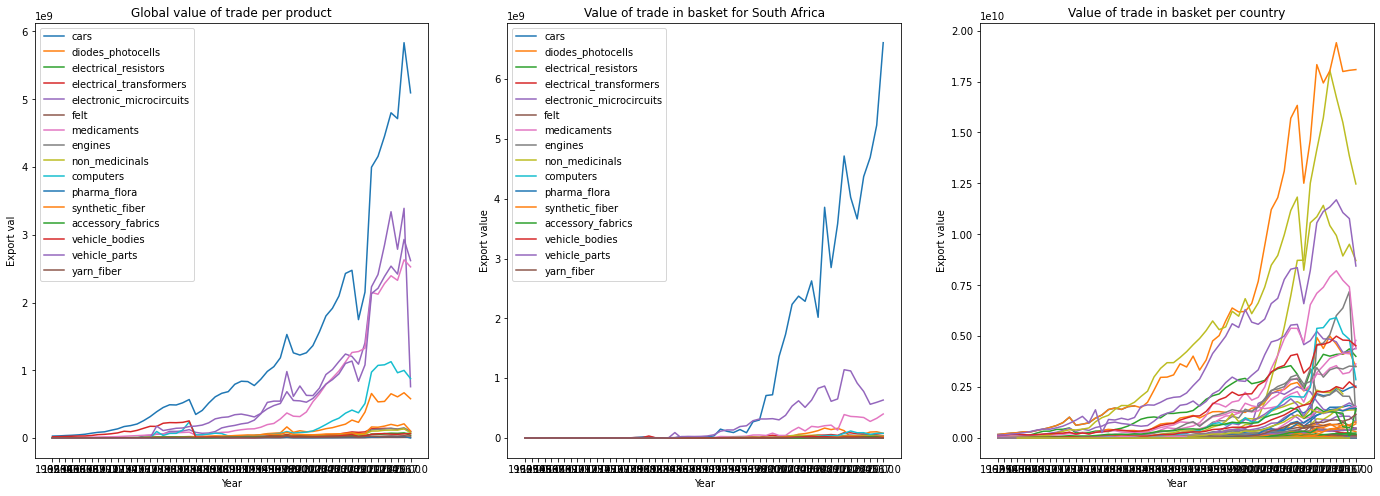

In [22]:
plt.figure(figsize=(24, 8))
plt.subplot(131)
plt.plot(agg_product) #/ agg_year_item.mean(0)[np.newaxis])
plt.title("Global value of trade per product")
plt.xlabel("Year")
plt.legend(agg_product.columns,loc="upper left")
plt.ylabel("Export val")

plt.subplot(133)
plt.plot(agg_country) #/ agg_year_store.mean(0)[np.newaxis])
plt.title("Value of trade in basket per country")
plt.xlabel("Year")
plt.ylabel("Export value")

plt.subplot(132)
plt.plot(agg_south_africa) #/ agg_year_store.mean(0)[np.newaxis])
plt.title("Value of trade in basket for South Africa")
plt.xlabel("Year")
plt.legend(agg_south_africa.columns,loc="upper left")
plt.ylabel("Export value")
plt.show()

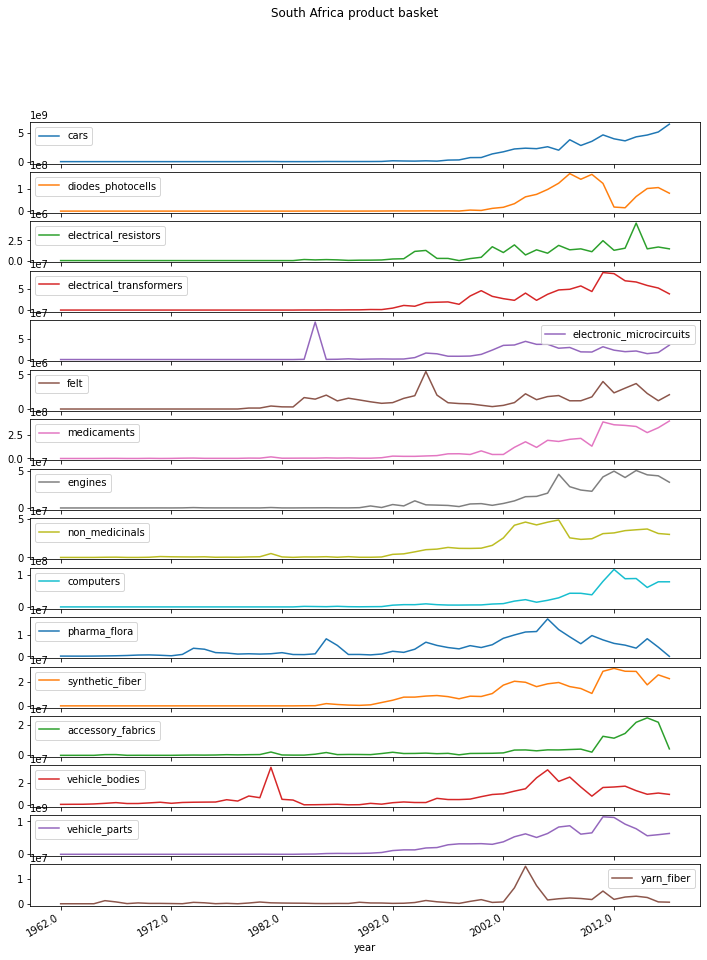

In [23]:
agg_south_africa.plot(subplots=True,figsize=(12, 16),title="South Africa product basket")
plt.show()

In [24]:
# https://pbpython.com/pandas-pivot-table-explained.html
agg_country_product = pd.pivot_table(trade_dframe[trade_dframe.product_name==id], index='year', columns='country', values='export_val', aggfunc=np.mean,fill_value=0)
agg_country_product.head()

year


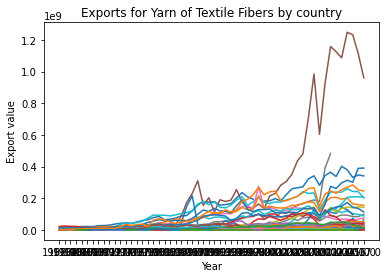

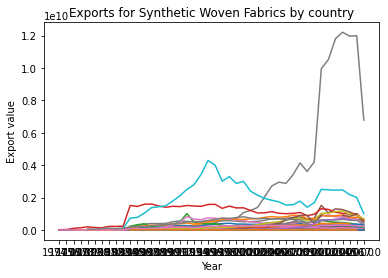

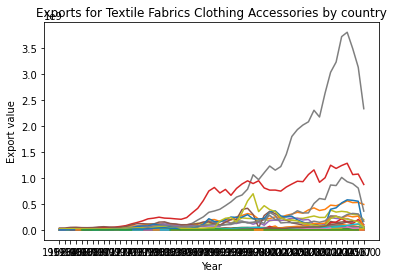

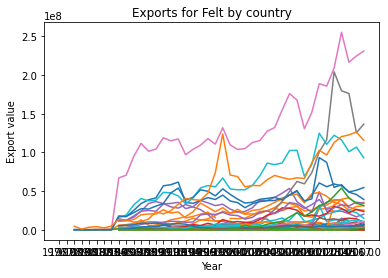

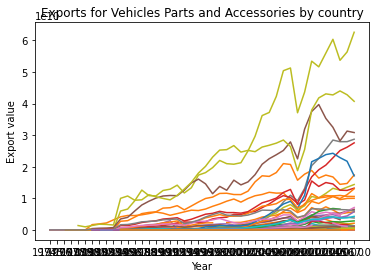

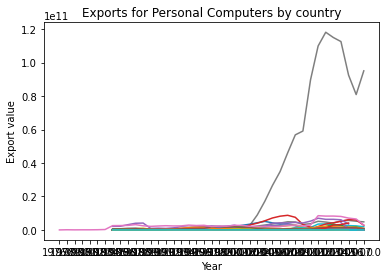

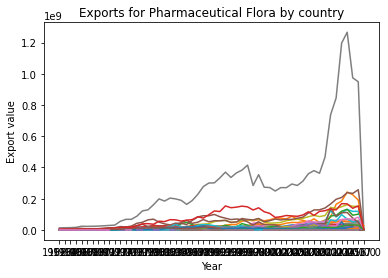

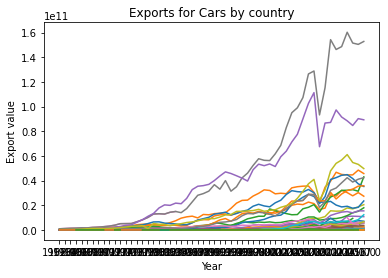

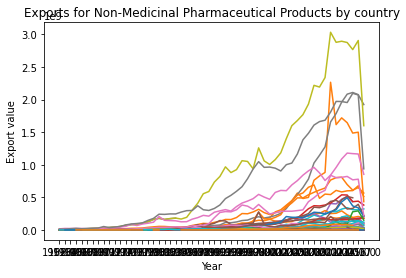

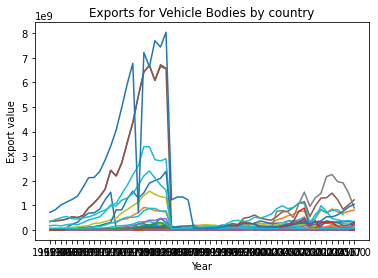

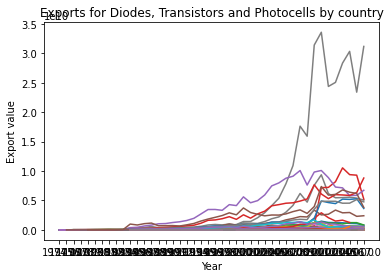

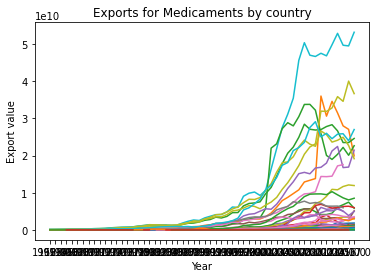

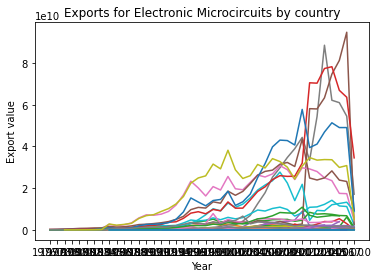

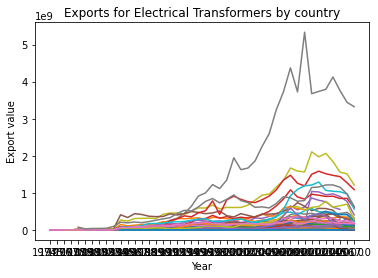

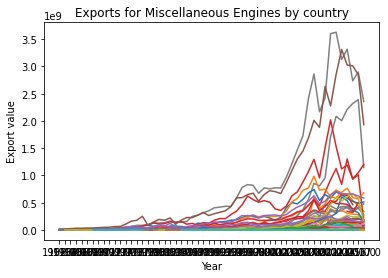

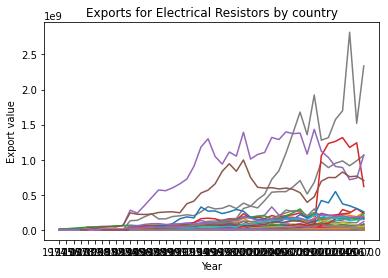

In [25]:
for id in trade_dframe.product_name.unique():
  product = pd.pivot_table(trade_dframe[trade_dframe.product_name==id], index='year', columns='country', values='export_val', aggfunc=np.mean)
  product.to_csv(f'{id}_sitc.csv')
  plt.plot(product)
  plt.title(f"Exports for {id} by country")
  plt.xlabel("Year")
  plt.ylabel("Export value")
  plt.show()

### Plotting functions (TODO)

In [ ]:
def plot_tile(result, ax, country_name):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,values,s=40,lw=.5,c=cmap(color_mapped(values)),edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',alpha=.1,
                    lw=0,zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='Add label', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('1960'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [ ]:
## Requires df.melt() for 2D plot
# origin = trade_dframe.country.unique()
# vals = trade_dframe[['country','export_val']]
# ncols = 5
# nrows = int(np.ceil(len(trade_dframe) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

# for i, (origin, vals) in enumerate(vals.items()):
#     if (len(result) >= 2):
#       plot_rt(vals, axes.flat[i], origin)
#     else:
#       break

# fig.tight_layout()
# fig.set_facecolor('w')

# Extract comprehensive features

### Packages

In [26]:
!pip install -q tsfresh 
import os
import logging
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

from tsfresh import extract_features, select_features
from tsfresh import defaults
from tsfresh.feature_extraction import feature_calculators
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh.utilities import dataframe_functions, profiling
from tsfresh.utilities.distribution import MapDistributor, MultiprocessingDistributor,DistributorBaseClass
from tsfresh.utilities.string_manipulation import convert_to_output_format

import tsfresh
from tsfresh.feature_extraction.settings import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### Extract features

In [27]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [28]:
trade_dframe.sitc_id.unique()

array([606519, 606531, 618471, 426571, 107849, 117522, 752924, 107810,
       425419, 107842, 117763, 425417, 117764, 137711, 107188, 117723])

In [29]:
trade_dframe[trade_dframe.sitc_id==606519].columns

Index(['export_rca', 'export_val', 'origin_id', 'sitc_id', 'year', 'country',
       'product_name'],
      dtype='object')

In [ ]:
def extract_product_features(df,fc_parameter):
  features_product = []
  extraction_method = fc_parameter.__class__.__name__
  for p in df.sitc_id.unique():
    product = df[df.sitc_id==p]
    p_features = extract_features(product[["export_val","year","country"]],
                                  column_id="country",
                                  column_sort="year",
                                  column_value=None,column_kind=None,
                                  chunksize=None,
                                  default_fc_parameters=fc_parameter)
    features_product.append(p_features)
    p_features.to_csv(f"{p}_{extraction_method}_expval.csv")
  print(features_product)
  return p_features, features_product

In [38]:
%timeit
fc_parameters=[EfficientFCParameters(),ComprehensiveFCParameters()]
extract_product_features(trade_dframe,fc_parameters[0])
extract_product_features(trade_dframe,fc_parameters[1])



Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

Feature Extraction:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

Feature Extraction:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

Feature Extraction:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

Feature Extraction:  80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

Feature Extraction: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

Feature Extraction:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

Feature Extraction:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]

Feature Extraction:  60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

Feature Extraction:  80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

Feature Extraction: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

Feature Extraction:  20%|██        | 1/5 [00:03<00:13,  3.49s/it]

Feature Extraction:  40%|████      | 2/5 [00:06<00:10,  3.39s/it]

Feature Extract

[variable           export_val__abs_energy  ...  export_val__variation_coefficient
id                                         ...                                   
Afghanistan                  1.484608e+10  ...                           1.253069
Albania                      3.152005e+10  ...                           2.134578
Algeria                      1.072405e+09  ...                           2.272953
American Samoa               1.263912e+10  ...                           0.758859
Andorra                      4.014874e+07  ...                           2.468261
...                                   ...  ...                                ...
Wallis and Futuna            1.514377e+09  ...                           2.236068
Yemen                        1.113540e+09  ...                           3.201792
Yugoslavia                   3.275736e+14  ...                           1.185525
Zambia                       1.160534e+10  ...                           4.095771
Zimbabwe       



Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

Feature Extraction:  20%|██        | 1/5 [00:03<00:12,  3.02s/it]

Feature Extraction:  40%|████      | 2/5 [00:06<00:09,  3.02s/it]

Feature Extraction:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

Feature Extraction:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

Feature Extraction: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

Feature Extraction:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

Feature Extraction:  40%|████      | 2/5 [00:06<00:09,  3.12s/it]

Feature Extraction:  60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

Feature Extraction:  80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

Feature Extraction: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

Feature Extraction:  20%|██        | 1/5 [00:03<00:13,  3.36s/it]

Feature Extraction:  40%|████      | 2/5 [00:06<00:10,  3.38s/it]

Feature Extract

[variable           export_val__abs_energy  ...  export_val__variation_coefficient
id                                         ...                                   
Afghanistan                  1.484608e+10  ...                           1.253069
Albania                      3.152005e+10  ...                           2.134578
Algeria                      1.072405e+09  ...                           2.272953
American Samoa               1.263912e+10  ...                           0.758859
Andorra                      4.014874e+07  ...                           2.468261
...                                   ...  ...                                ...
Wallis and Futuna            1.514377e+09  ...                           2.236068
Yemen                        1.113540e+09  ...                           3.201792
Yugoslavia                   3.275736e+14  ...                           1.185525
Zambia                       1.160534e+10  ...                           4.095771
Zimbabwe       

(variable        export_val__abs_energy  ...  export_val__variation_coefficient
 id                                      ...                                   
 Afghanistan               2.589063e+10  ...                           3.419965
 Albania                   6.802910e+11  ...                           2.527058
 Algeria                   4.663659e+09  ...                           1.509858
 American Samoa            5.083956e+09  ...                           1.589413
 Andorra                   8.598618e+09  ...                           2.409164
 ...                                ...  ...                                ...
 Western Sahara            4.581953e+09  ...                           0.953551
 Yemen                     1.738607e+09  ...                           3.014321
 Yugoslavia                2.564168e+14  ...                           0.953126
 Zambia                    1.601204e+10  ...                           3.016887
 Zimbabwe                  2.718926e+09 